<a href="https://colab.research.google.com/github/guilhermecgs/apdoac/blob/master/apdoac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dados da tese de mestrado APDOAC

In [2]:
!npx degit guilhermecgs/apdoac/dados -f

npx: installed 1 in 1.132s
> destination directory is not empty. Using --force, continuing
! zlib: unexpected end of file


In [3]:
! pip install pandas
! pip install tqdm
! pip install xlsx2csv
! pip install genderbr
! pip install --upgrade genderbr

Requirement already up-to-date: genderbr in /usr/local/lib/python3.6/dist-packages (0.1.2)


In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML


In [5]:
init = False
if init:
  df_cnpq_2002_2019 = pd.read_excel('cnpq_2002-2019_pq.xlsx')

  def primeiro_nome(nome):
    return nome.split(' ')[0]

  df_cnpq_2002_2019['primeiro_nome'] = df_cnpq_2002_2019['Beneficiário'].apply(lambda nome: primeiro_nome(nome))

  primeiros_nomes_unicos = df_cnpq_2002_2019['primeiro_nome'].unique()

  from genderbr import get_gender

  result = {}
  for primeiro_nome in tqdm(primeiros_nomes_unicos):
    result[primeiro_nome] = str(get_gender(primeiro_nome))
    print(primeiro_nome + result[primeiro_nome])

  df_cnpq_2002_2019['sexo'] = df_cnpq_2002_2019['primeiro_nome'].apply(lambda primeiro_nome: result[primeiro_nome])

  df_cnpq_2002_2019.to_excel('cnpq_2002-2019_pq_com_sexo.xlsx')
  df_cnpq_2002_2019.to_csv('cnpq_2002-2019_pq_com_sexo.csv')


In [6]:
import os
import glob
from tqdm.notebook import trange, tqdm
from xlsx2csv import Xlsx2csv
  

def concat(pathname):
  arquivos = glob.glob(pathname)
  print('Unindo arquivos:')
  print('\n    -'.join(arquivos))

  dfs = []
  for arquivo in tqdm(arquivos):
    arquivo_csv = arquivo.replace('xlsx', 'csv')
    if not os.path.isfile(arquivo_csv):
      Xlsx2csv(arquivo, outputencoding="utf-8").convert(arquivo.replace('xlsx', 'csv'))

    dfs.append(pd.read_csv(arquivo_csv))
    
  return pd.concat(dfs)


In [8]:
df_pq = concat('*.xlsx')
df_discentes = concat('discente/*.xlsx')
df_docentes = concat('docente/*.xlsx')
 

Unindo arquivos:
cnpq_2002-2019_pq_com_sexo.xlsx



Unindo arquivos:
discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2013.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2016.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2015.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2014.xlsx


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):



Unindo arquivos:
docente/br-capes-colsucup-docente-2018-2020-06-12.xlsx
    -docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2014.xlsx
    -docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2013.xlsx
    -docente/br-capes-colsucup-curso-2017-2020-06-12.xlsx
    -docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2016.xlsx
    -docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2015.xlsx


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [10]:
df_pq['Grande Área'].unique()

array(['Lingüística, Letras e Artes', 'Ciências Exatas e da Terra',
       'Ciências Biológicas', 'Ciências Humanas', 'Engenharias',
       'Ciências Agrárias', 'Ciências da Saúde',
       'Ciências Sociais Aplicadas', 'Outra', 'Indefinido'], dtype=object)

In [14]:
def por_ano(df, grau='PQ - Produtividade em Pesquisa'):

  if 'TP_SEXO_DOCENTE' in df.columns:
    coluna_sexo = 'TP_SEXO_DOCENTE'
    coluna_grau = 'NM_GRAU_PROGRAMA'
    categoria = 'docentes'
    coluna_grande_area = 'NM_GRANDE_AREA_CONHECIMENTO'
    valor_masculino = 'MASCULINO'
    valor_feminino = 'FEMININO'
    coluna_ano = 'AN_BASE'

  if 'TP_SEXO_DISCENTE' in df.columns:
    coluna_sexo = 'TP_SEXO_DISCENTE'
    coluna_grau = 'NM_GRAU_PROGRAMA'
    categoria = 'discentes'
    coluna_grande_area = 'NM_GRANDE_AREA_CONHECIMENTO'
    valor_masculino = 'MASCULINO'
    valor_feminino = 'FEMININO'
    coluna_ano = 'AN_BASE'

  if 'Beneficiário' in df.columns:
    coluna_sexo = 'sexo'
    coluna_grau = 'Modalidade'
    categoria = 'PQ - Produtividade em Pesquisa'
    coluna_grande_area = 'Grande Área'
    valor_masculino = 'M'
    valor_feminino = 'F'
    coluna_ano = 'Ano Referência'

  df_filtrado = df[df[coluna_grau] == grau]

  anos = df.dropna(subset=[coluna_ano])[coluna_ano].unique()
  anos = list(range(int(anos.min()), int(anos.max()) + 1, 1))
  anos.sort()
  
  values_m = []
  values_f = []

  def obtem_numero(sexo, ano):
    total = len(df_filtrado[((df_filtrado[coluna_grande_area].str.lower() == 'engenharias')  
                      | (df_filtrado[coluna_grande_area].str.lower() == 'ciências exatas e da terra')) 
                      & ((df_filtrado[coluna_sexo] == valor_masculino) | (df_filtrado[coluna_sexo] == valor_feminino))
                      & (df_filtrado[coluna_ano] == ano)])
    
    para_o_sexo = len(df_filtrado[((df_filtrado[coluna_grande_area].str.lower() == 'engenharias')  
                      | (df_filtrado[coluna_grande_area].str.lower() == 'ciências exatas e da terra')) 
                      & (df_filtrado[coluna_sexo] == sexo)
                      & (df_filtrado[coluna_ano] == ano)])

    if total:
      return para_o_sexo / total * 100.0
    else:
      return 0

  for ano in anos:
    values_m.append(obtem_numero(valor_masculino, ano))
    values_f.append(obtem_numero(valor_feminino, ano))
    
  df = pd.DataFrame({'MASCULUNO': values_m, 'FEMINIMO': values_f}, index=map(int, anos))
  ax = df.plot.bar(figsize=(15, 10), title='Percentual de bolsas de {grau} por ano para {categoria}'
        .format(grau=grau.lower(), categoria=categoria))
  ax.grid(True)
  ax.set_xlabel("Ano")
  ax.set_ylim([0,100])
  ax.set_ylabel("Percentual de bolsas de {grau} para {categoria}".format(grau=grau.lower(), categoria=categoria))
  ax.legend(loc='upper right')

  for p in ax.patches:
    if round(p.get_height()):
      ax.annotate(str(int(round(p.get_height()))) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))

In [15]:
def por_curso(df, grau='PQ - Produtividade em Pesquisa'):

  if 'TP_SEXO_DOCENTE' in df.columns:
    coluna_sexo = 'TP_SEXO_DOCENTE'
    coluna_grau = 'NM_GRAU_PROGRAMA'
    categoria = 'docentes'
    coluna_grande_area = 'NM_GRANDE_AREA_CONHECIMENTO'
    valor_masculino = 'MASCULINO'
    valor_feminino = 'FEMININO'
    coluna_ano = 'AN_BASE'

  if 'TP_SEXO_DISCENTE' in df.columns:
    coluna_sexo = 'TP_SEXO_DISCENTE'
    coluna_grau = 'NM_GRAU_PROGRAMA'
    categoria = 'discentes'
    coluna_grande_area = 'NM_GRANDE_AREA_CONHECIMENTO'
    valor_masculino = 'MASCULINO'
    valor_feminino = 'FEMININO'
    coluna_ano = 'AN_BASE'

  if 'Beneficiário' in df.columns:
    coluna_sexo = 'sexo'
    coluna_grau = 'Modalidade'
    categoria = 'PQ - Produtividade em Pesquisa'
    coluna_grande_area = 'Grande Área'
    valor_masculino = 'M'
    valor_feminino = 'F'
    coluna_ano = 'Ano Referência'

  df_filtrado = df[df[coluna_grau] == grau]

  areas = df[coluna_grande_area].unique()
  values_m = []
  values_f = []

  def obtem_numero(sexo, area):
    total = len(df_filtrado[df_filtrado[coluna_grande_area] == area])
    para_o_sexo = len(df_filtrado[(df_filtrado[coluna_sexo] == sexo)
                                    & (df_filtrado[coluna_grande_area] == area)])
  
    return para_o_sexo / total * 100.0

  for area in areas:
    values_m.append(obtem_numero(valor_masculino, area))
    values_f.append(obtem_numero(valor_feminino, area))
    
  df = pd.DataFrame({'MASCULUNO': values_m, 'FEMINIMO': values_f}, index=areas)
  ax = df.plot.bar(figsize=(15, 10), title='Percentual de bolsas de {grau} por grande área de conhecimento para {categoria}'
        .format(grau=grau.lower(), categoria=categoria))
  ax.grid(True)
  ax.set_xlabel("Grande área de conhecimento")
  ax.set_ylim([0,100])
  ax.set_ylabel("Percentual de bolsas de {grau} para {categoria}".format(grau=grau.lower(), categoria=categoria))
  ax.legend(loc='upper right')

  for p in ax.patches:
    if round(p.get_height()):
      ax.annotate(str(int(round(p.get_height()))) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))

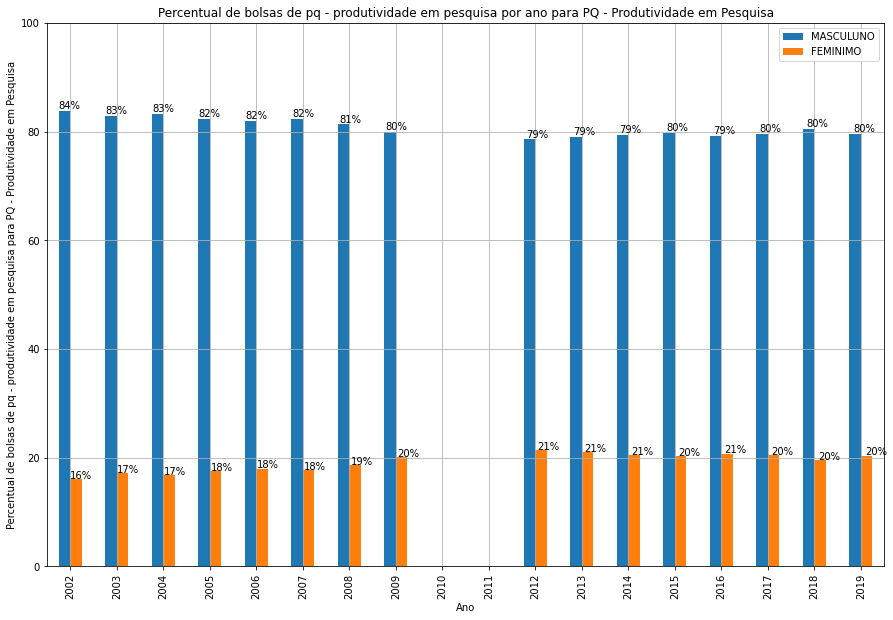

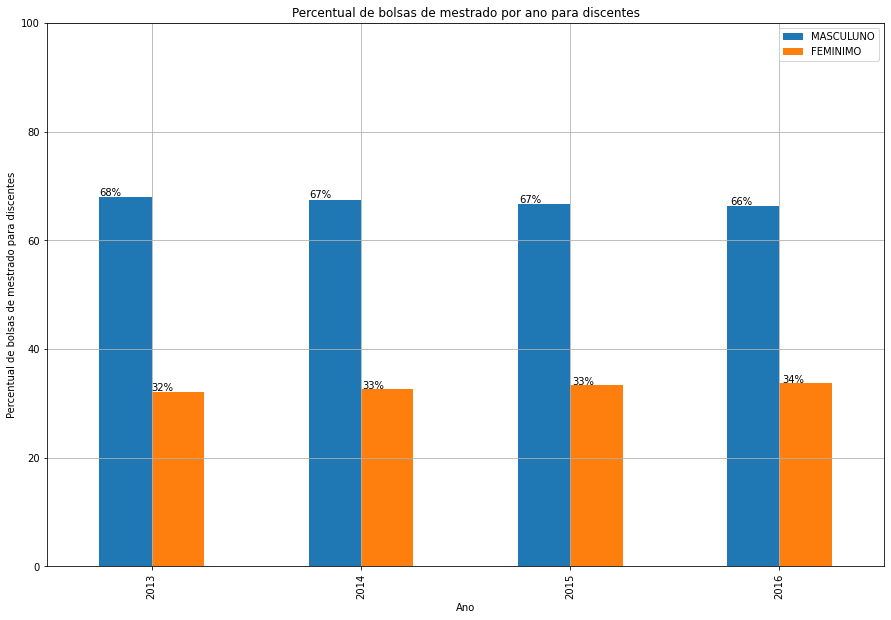

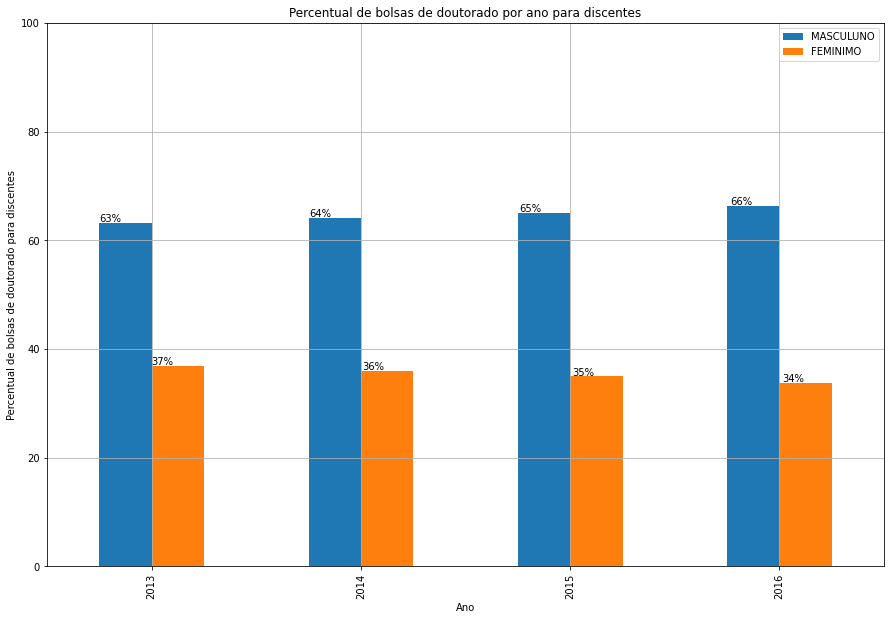

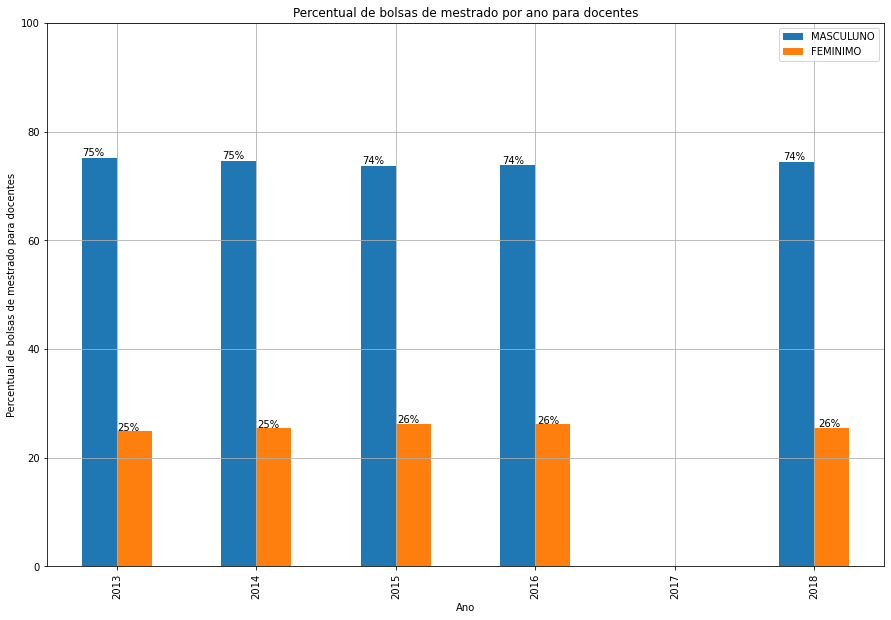

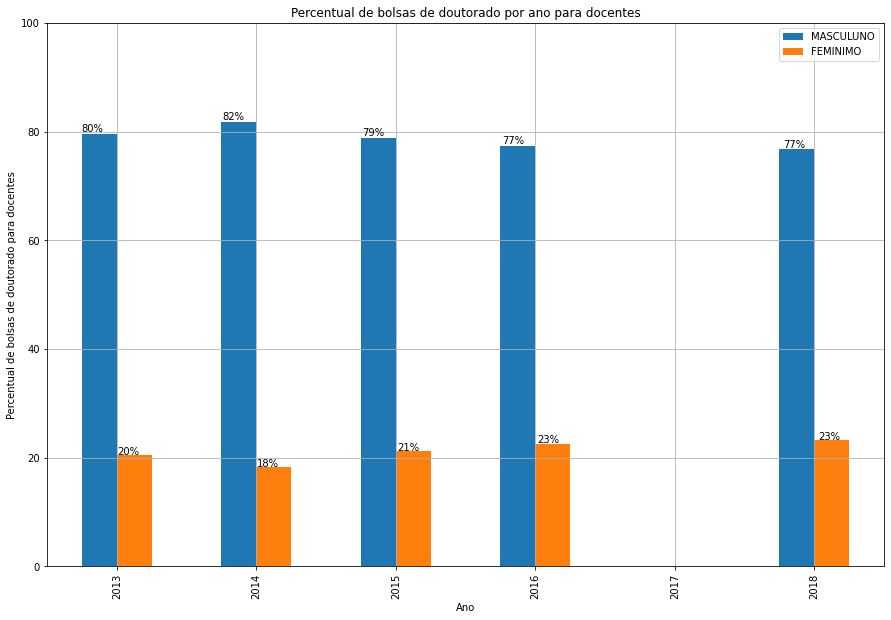

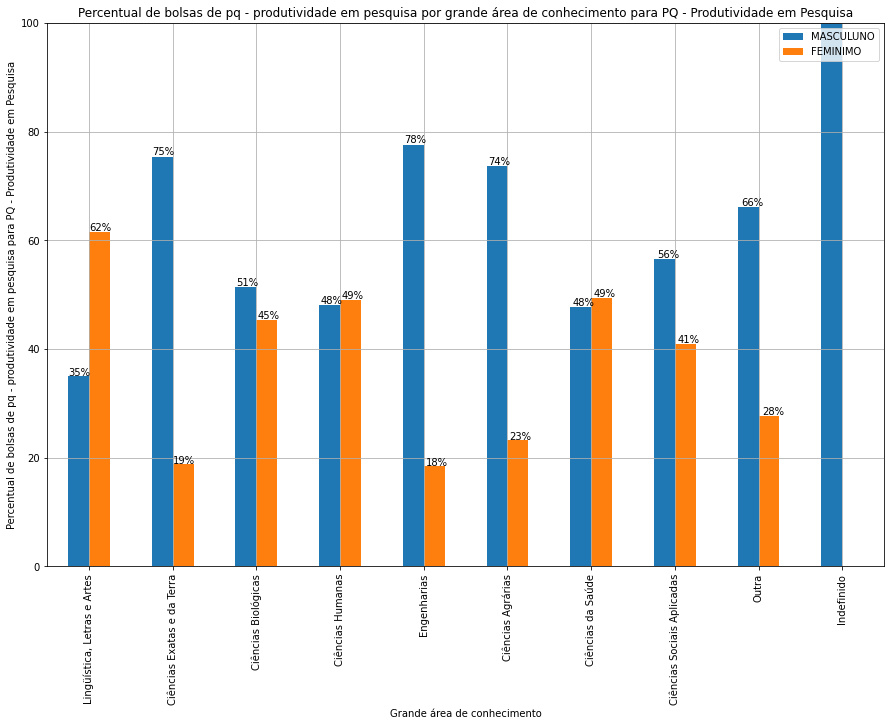

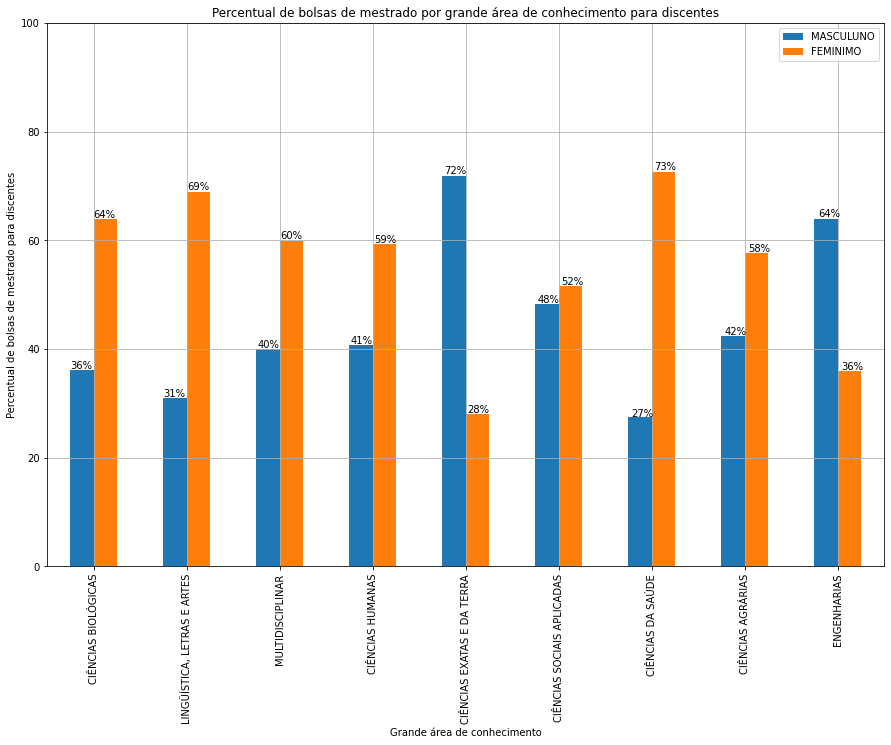

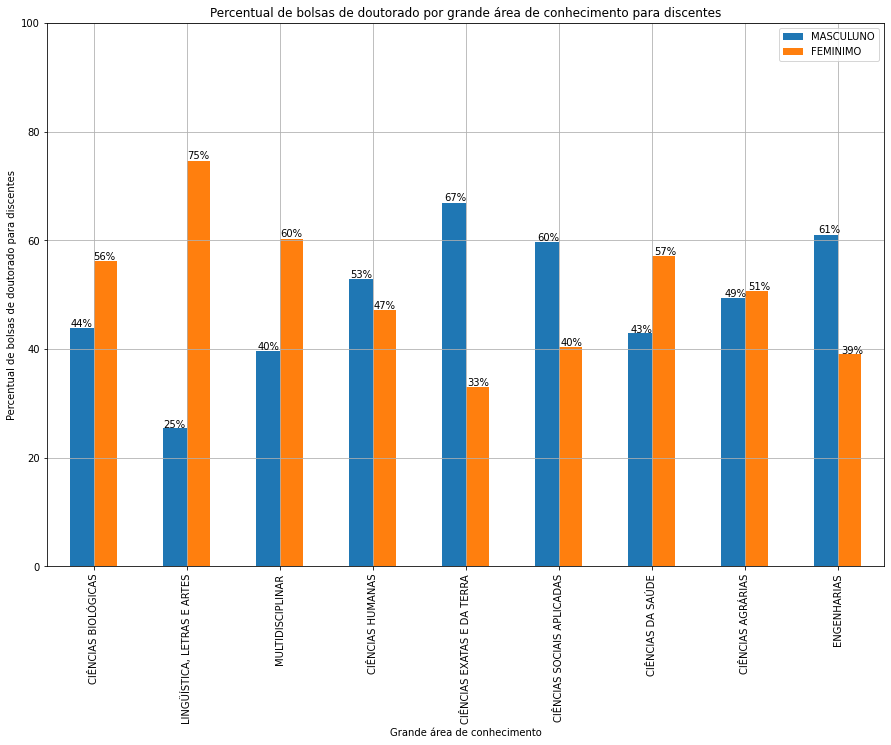

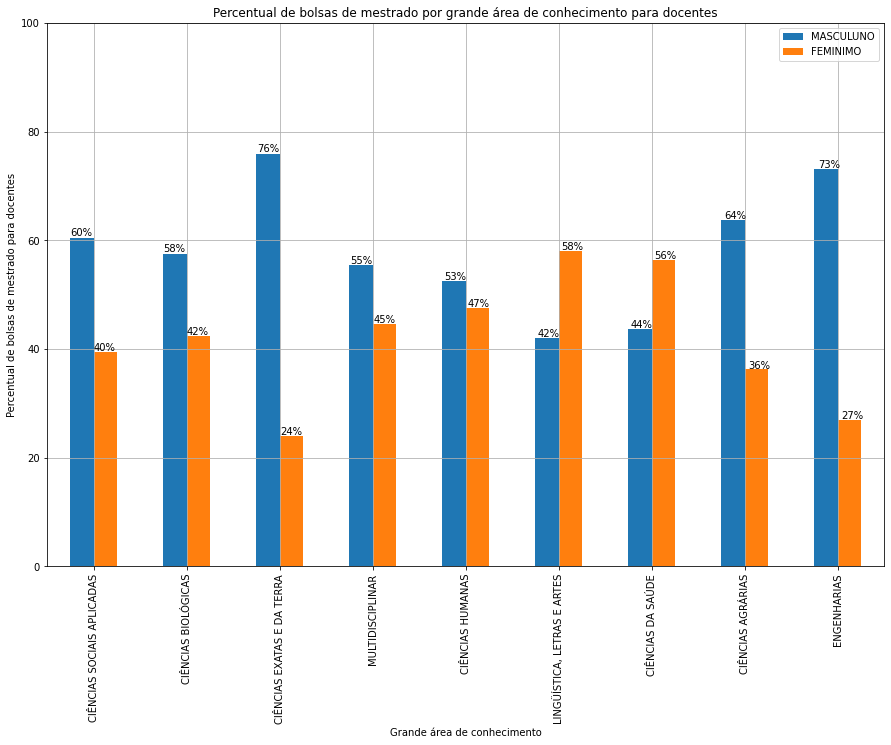

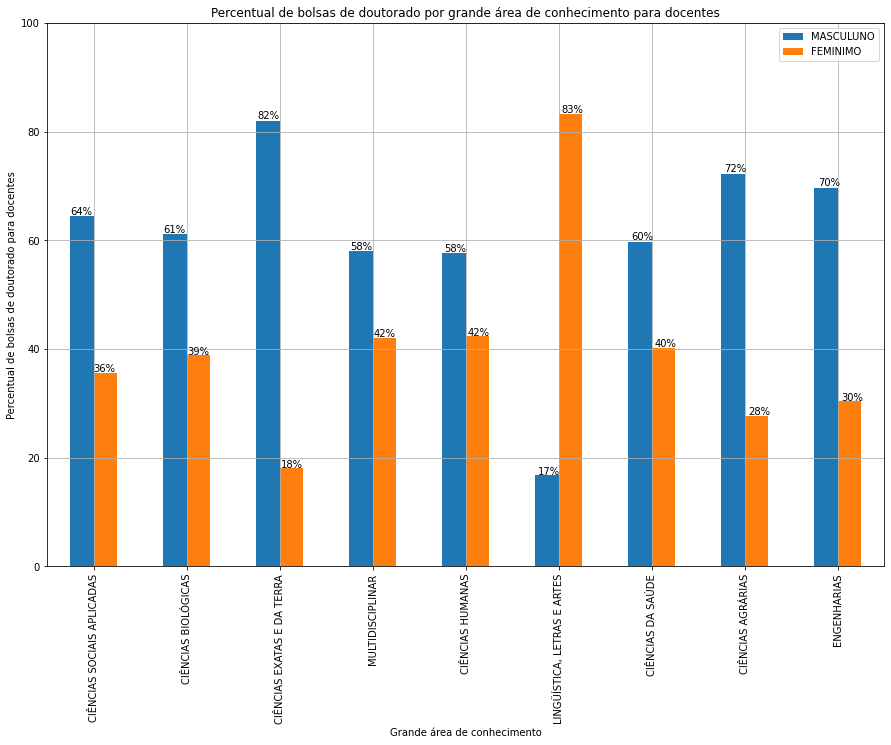

In [16]:
por_ano(df_pq)
por_ano(df_discentes, 'MESTRADO')
por_ano(df_discentes, 'DOUTORADO')
por_ano(df_docentes, grau='MESTRADO')
por_ano(df_docentes, grau='DOUTORADO')

por_curso(df_pq)
por_curso(df_discentes, grau='MESTRADO')
por_curso(df_discentes, grau='DOUTORADO')
por_curso(df_docentes, grau='MESTRADO')
por_curso(df_docentes, grau='DOUTORADO')

